In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [319]:
os.chdir('C:/Storage/StudyJourney/Nam3/Cs114/Project2')

In [320]:
# Đọc dữ liệu
annonimized = pd.read_csv("Dataset/annonimized.csv")
qt = pd.read_csv("Dataset/public_it001/qt-public.csv")

In [321]:
# Hàm xử lý cột `judgement` để rút trích các đặc trưng
import json

def extract_judgement_features(df):
    # Parse cột judgement thành dict với kiểm tra ngoại lệ
    def safe_json_loads(j):
        try:
            return json.loads(j) if isinstance(j, str) else {}
        except json.JSONDecodeError:
            return {}

    # Chuyển cột judgement sang dạng dict
    df['judgement_parsed'] = df['judgement'].apply(safe_json_loads)
    
    # Rút trích các giá trị từ judgement
    df['times'] = df['judgement_parsed'].apply(lambda x: x.get('times', []) if isinstance(x, dict) else [])
    df['mems'] = df['judgement_parsed'].apply(lambda x: x.get('mems', []) if isinstance(x, dict) else [])
    
    # Kiểm tra kiểu của verdicts và xử lý
    def extract_verdicts(verdicts):
        if isinstance(verdicts, dict):
            return verdicts.get('WRONG', 0)
        return 0  # Mặc định nếu verdicts không phải là dict

    df['verdicts'] = df['judgement_parsed'].apply(lambda x: x.get('verdicts', {}) if isinstance(x, dict) else {})
    df['wrong_testcases'] = df['verdicts'].apply(extract_verdicts)
    df['accepted'] = df['verdicts'].apply(lambda x: 1 if isinstance(x, list) else -1)

    return df

def process_times_and_mems(df):
    df['times_mean'] = df['times'].apply(lambda x: sum(x) / len(x) if x else -1)
    df['mems_mean'] = df['mems'].apply(lambda x: sum(x) / len(x) if x else -1)

In [322]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats

# Hàm chuyển đổi thời gian với ngày tham chiếu
reference_date = datetime(2023, 9, 1)

def convert_to_datetime(date_str, default_year=2024):
    return datetime.strptime(f"{default_year}-{date_str}", "%Y-%m-%d %H:%M:%S")

# Chuyển đổi 'created_at' và 'updated_at' thành ordinal và thêm đặc trưng chênh lệch ngày
annonimized['created_at'] = pd.to_datetime(annonimized['created_at'], errors='coerce')
annonimized['updated_at'] = pd.to_datetime(annonimized['updated_at'], errors='coerce')
annonimized['created_at_ordinal'] = (annonimized['created_at'] - reference_date).dt.days
annonimized['updated_at_ordinal'] = (annonimized['updated_at'] - reference_date).dt.days
annonimized['date_diff'] = (annonimized['updated_at'] - annonimized['created_at']).dt.total_seconds()

# Tính toán các đặc trưng nhóm
submission_count = annonimized.groupby(['username', 'assignment_id', 'problem_id']).size().reset_index(name='submission_count')
status_count = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['status'].value_counts().unstack(fill_value=0).reset_index()
avg_score = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['pre_score'].mean().reset_index(name='avg_score')
error_rate = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['judgement'].apply(lambda x: x.str.contains('WRONG').sum() / len(x)).reset_index(name='error_rate')

# Z-score và kiểm tra ngoại lệ
annonimized['z_score'] = stats.zscore(annonimized['pre_score'])
annonimized['is_outlier'] = annonimized['z_score'].apply(lambda x: 1 if abs(x) > 3 else 0)

# Đặc trưng hoạt động theo giờ
annonimized['hour'] = annonimized['created_at'].dt.hour
hourly_activity = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['hour'].value_counts().unstack(fill_value=0).reset_index()

# Label encoding cho cột 'status'
label_encoder = LabelEncoder()
annonimized['status_encoded'] = label_encoder.fit_transform(annonimized['status'])

# Thêm các đặc trưng tổng hợp
annonimized['submission_time_diff'] = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['created_at'].diff().dt.total_seconds()
annonimized['avg_submission_time_diff'] = annonimized.groupby(['username', 'assignment_id', 'problem_id'])['submission_time_diff'].transform('mean')

annonimized = extract_judgement_features(annonimized)


annonimized['status_encoded'] = label_encoder.fit_transform(annonimized['status'])

annonimized['submission_count'] = annonimized.groupby('username')['is_final'].transform('count')

annonimized['avg_pre_score'] = annonimized.groupby('username')['pre_score'].transform('mean')

annonimized['avg_score_per_submission'] = annonimized['avg_pre_score'] / (annonimized['submission_count'] + 1e-5)  # Tránh chia cho 0

annonimized['is_final_ratio'] = annonimized['is_final'] / annonimized['submission_count']

annonimized['problem_final_ratio'] = annonimized.groupby(
    ['username', 'assignment_id', 'problem_id'])['is_final'].transform(lambda x: x.sum() / (len(x) + 1e-5))

annonimized['problem_submission_count'] = annonimized.groupby(
    ['username', 'assignment_id', 'problem_id'])['is_final'].transform('count')

annonimized = annonimized.groupby('username').agg({
    'status_encoded': 'mean',
    'is_final': 'mean',
    'avg_submission_time_diff': 'mean',
    'wrong_testcases': 'mean',
    'accepted': 'mean',
    'created_at_ordinal': 'mean',
    'updated_at_ordinal': 'mean',
    'date_diff': 'mean',
    'hour': 'mean',
    'z_score': 'mean',
    'is_outlier': 'mean',
    'submission_count': 'mean',
    'avg_pre_score': 'mean',
    'is_final_ratio': 'mean',
    'problem_submission_count': 'mean',
    'problem_final_ratio': 'mean'
}).reset_index()

# Nhóm và tổng hợp các đặc trưng
# features = ['username', 'status_encoded', 'submission_count', 'avg_pre_score', 
#             'avg_score_per_submission', 'is_final_ratio', 'problem_submission_count', 
#             'avg_submission_time_diff', 'problem_final_ratio', 'wrong_testcases', 
#             'accepted', 'date_diff', 'hour']

# features_nouser = ['status_encoded', 'submission_count', 'avg_pre_score', 
#             'avg_score_per_submission', 'is_final_ratio', 'problem_submission_count', 
#             'avg_submission_time_diff', 'problem_final_ratio', 'wrong_testcases', 
#             'accepted', 'date_diff', 'hour']

features = ['username','status_encoded','problem_final_ratio','is_final_ratio', 'is_final','submission_count']

features_nouser = ['status_encoded','problem_final_ratio','is_final_ratio', 'is_final','submission_count']


annonimized = annonimized[features]


In [323]:
# Merge dữ liệu: giữ tất cả các username từ annonimized
data = annonimized.merge(qt, on="username", how="left")

In [324]:
data['QT'] = pd.to_numeric(data['QT'], errors='coerce')
data['QT'] = data.groupby('username')['QT'].mean().values

In [325]:
# Phân tách dữ liệu
train_test_data = data[data['QT'].notna()]  # Sinh viên có điểm, dùng để train
predict_data = data[data['QT'].isna()]  # Sinh viên không có điểm, dùng để dự đoán

# In số lượng
print(f"Số lượng sinh viên có điểm (train): {train_test_data.shape[0]}")
print(f"Số lượng sinh viên cần dự đoán: {predict_data.shape[0]}")

Số lượng sinh viên có điểm (train): 754
Số lượng sinh viên cần dự đoán: 735


In [326]:
X_train_test_data = train_test_data[features_nouser]
y_train_test_data = train_test_data['QT']

In [327]:
nan_columns = X_train_test_data.columns[X_train_test_data.isna().any()]
print(f"Các cột chứa NaN: {nan_columns.tolist()}")
nan_counts = X_train_test_data.isna().sum()
print("Số lượng NaN trong mỗi cột:")
print(nan_counts[nan_counts > 0])
X_train_test_data[nan_columns] = X_train_test_data[nan_columns].fillna(X_train_test_data[nan_columns].mean())

Các cột chứa NaN: []
Số lượng NaN trong mỗi cột:
Series([], dtype: int64)


In [328]:
x_train, x_test, y_train, y_test = train_test_split(X_train_test_data, y_train_test_data, test_size=0.3, random_state=42)

In [329]:
# Huấn luyện mô hình
models = {
    'LinearRegression': LinearRegression(),
    # 'RandomForest': RandomForestRegressor(random_state=42),
    # 'XGBoost': XGBRegressor(random_state=42)
}

metrics = {}

for name, model in models.items():
    # Huấn luyện
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Đánh giá
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics[name] = {
        'MSE': mse,
        'R2': r2
    }

# 7. In kết quả
print("Model Evaluation Results:")
for name, metrics in metrics.items():
    print(f"{name}: MSE={metrics['MSE']:.4f}, R2={metrics['R2']:.4f}")

Model Evaluation Results:
LinearRegression: MSE=2.2720, R2=0.0391


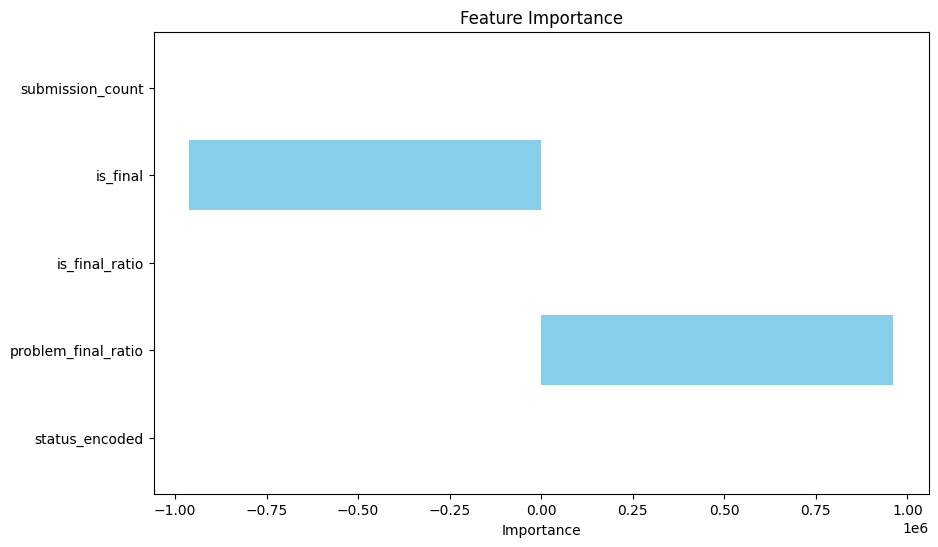

In [330]:
# Mức độ quan trọng của các đặc trưng
importances = model.coef_
features = X_train_test_data.columns

# Vẽ biểu đồ mức độ quan trọng
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [331]:
results = {}

results = {  
    'y_val': y_test,  
    'y_pred': y_pred  
} 

results_df = pd.DataFrame(results)
results_df.to_csv("Predict/train_predicted_QT.csv", index=False)

In [332]:
X_predict_data = predict_data[features_nouser]

In [333]:
nan_columns = X_predict_data.columns[X_predict_data.isna().any()]
print(f"Các cột chứa NaN: {nan_columns.tolist()}")
nan_counts = X_predict_data.isna().sum()
print("Số lượng NaN trong mỗi cột:")
print(nan_counts[nan_counts > 0])
X_predict_data[nan_columns] = X_predict_data[nan_columns].fillna(X_predict_data[nan_columns].mean())

Các cột chứa NaN: []
Số lượng NaN trong mỗi cột:
Series([], dtype: int64)


In [334]:
predict_data['QT'] = model.predict(X_predict_data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_218584\2934331168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['QT'] = model.predict(X_predict_data)


In [335]:
# Xuất file kết quả
output = predict_data[['username', 'QT']].to_csv("Predict/predicted_QT.csv", index=False, header=False)